## Learning Lyapunov function for Simple Pendulum (Baseline vs CC vs DRCC)

In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/MyDrive/Colab Notebooks/' 

root_dir = "/content/gdrive/MyDrive/"

# choose where you want your project files to be saved
project_folder = "Neural_Lyapunov_Function"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  # !touch 'new_file_in_working_directory.txt'
  # print('\nYour working directory was changed to ' + root_dir + project_folder + \
  #       "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)

Mounted at /content/gdrive


In [2]:
# -*- coding: utf-8 -*-
# import pkgutil
# if not pkgutil.find_loader("dreal"):
#   !curl https://raw.githubusercontent.com/dreal/dreal4/master/setup/ubuntu/18.04/install.sh | bash
#   !pip install dreal --upgrade

import torch 
import torch.nn.functional as F
import numpy as np
import timeit 
import matplotlib.pyplot as plt
import torch.utils.data as data

#Define the Network Architecture and Loss Function

In [3]:
# the following is a nn with depth 2 (2 hidden layers)
class LyapunovNet(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(LyapunovNet, self).__init__()
        torch.manual_seed(2)
        self.layer1 = torch.nn.Linear(n_input, n_hidden)
        self.layer2 = torch.nn.Linear(n_hidden, n_hidden) 
        self.layer3 = torch.nn.Linear(n_hidden, n_hidden)               
        self.layer4 = torch.nn.Linear(n_hidden, n_output)               

        self.activation = torch.nn.Tanh()
        torch.nn.init.xavier_uniform_(self.layer1.weight)
        torch.nn.init.xavier_uniform_(self.layer2.weight)
        torch.nn.init.xavier_uniform_(self.layer3.weight)
        torch.nn.init.xavier_uniform_(self.layer4.weight)

    def forward(self, x):
        h_1 = self.activation(self.layer1(x))
        h_2 = self.activation(self.layer2(h_1))
        h_3 = self.activation(self.layer3(h_2))
        out = self.layer4(h_3)
        return out

    def print_weights(self):
        print("Layer 1 weights:\n", self.layer1.weight)
        print("Layer 1 biases:\n", self.layer1.bias)
        print("Layer 2 weights:\n", self.layer2.weight)
        print("Layer 2 biases:\n", self.layer2.bias)
        print("Layer 3 weights:\n", self.layer3.weight)
        print("Layer 3 biases:\n", self.layer3.bias)
        print("Layer 4 weights:\n", self.layer4.weight)
        print("Layer 4 biases:\n", self.layer4.bias)
      

#1st V definition, this way has v(0) = 0 by construction
def V_theta(net, x, alpha=0.5):
    origin = torch.tensor([[np.cos(0), np.sin(0), 0]], dtype=torch.float32)
    phi_x = net(x)
    phi_0 = net(origin)
    #V = torch.abs(phi_x - phi_0) + alpha * torch.norm(x - origin, dim=1, keepdim=True)
    V = torch.norm(phi_x - phi_0, dim=1, keepdim=True)**2 + alpha * torch.norm(x - origin, dim=1, keepdim=True)**2
    return V


## Pendulum system

In [4]:
#3 state version
def pendulum_dynamics(x):
    cos_theta = x[:, 0]
    sin_theta = x[:, 1]
    omega = x[:, 2]

    theta = torch.atan2(sin_theta, cos_theta)
    m = 1      # mass
    l = 0.5    # length
    b = 0.1    # damping
    g = 9.81   # gravity

    cos_theta_dot = -sin_theta * omega
    sin_theta_dot = cos_theta * omega
    omega_dot = (-b * omega - m * g * l * sin_theta) / (m * l * l)

    return torch.stack([cos_theta_dot, sin_theta_dot, omega_dot], dim=1)

## Training Parameters

In [5]:
n_input = 3
n_hidden = 64
n_output = 8
num_epochs = 3000
num_samples = 10000
learning_rate = 0.002
loss_threshold = 1e-4
batch_size = 128

# Instantiate the network and optimizer
net_nominal = LyapunovNet(n_input, n_hidden, n_output)
optimizer = torch.optim.Adam(net_nominal.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# Generate the training samples within the square region of (-2.5, 2.5)
x_original = torch.Tensor(num_samples, 2).uniform_(-8, 8)
x_original.requires_grad = True

# Initialize x_train with zeros (the input dimension is 3, by rewriting \theta as cos and sin)
x_train = torch.zeros([num_samples, n_input], requires_grad=True)

# Create a new tensor with the same properties as x_train
x_train_temp = torch.zeros_like(x_train)

# Use vectorized operations to fill x_train_temp
x_train_temp[:, 0] = torch.sin(x_original[:, 0])
x_train_temp[:, 1] = torch.cos(x_original[:, 0])
x_train_temp[:, 2] = x_original[:, 1]

# Assign x_train_temp to x_train
x_train.data = x_train_temp.data


## Baseline Training 

In [6]:
#this is the baseline loss function 
def lyapunov_derivative_loss(V_dot, x, gamma=0.1):
    positive_part = torch.relu(V_dot + gamma * torch.norm(x, dim=1))
    return torch.mean(positive_part)


gamma = 0.1

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()

    V = V_theta(net_nominal, x_train)
    x_dot = pendulum_dynamics(x_train)
    V_dot = torch.autograd.grad(V, x_train, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_dot = torch.sum(V_dot * x_dot, dim=1)

    loss = lyapunov_derivative_loss(V_dot, x_train, gamma)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')

    if loss.item() < loss_threshold:
        print(f'Training stopped at epoch {epoch + 1}, Loss: {loss.item():.4f}')
        break

# After training, print the weights for investigation
net_nominal.print_weights()


#mini-batch training
# train_dataset = data.TensorDataset(x_train)
# train_loader = data.DataLoader(train_dataset, batch_size=batch_size)

# gamma = 0.1

# for epoch in range(num_epochs):
#     epoch_loss = 0.0
#     num_batches = 0
    
#     # Shuffle the indices
#     indices = torch.randperm(x_train.size(0))
    
#     for i in range(0, x_train.size(0), batch_size):
#         # Create non-overlapping mini-batches
#         batch_indices = indices[i:i + batch_size]
#         x_batch = x_train[batch_indices]
        
#         optimizer.zero_grad()

#         V = V_theta(net_nominal, x_batch)
#         x_dot = pendulum_dynamics(x_batch)
#         V_dot = torch.autograd.grad(V, x_batch, grad_outputs=torch.ones_like(V), create_graph=True)[0]
#         V_dot = torch.sum(V_dot * x_dot, dim=1)

#         loss = lyapunov_derivative_loss(V_dot, x_batch, gamma)
#         loss.backward()
#         optimizer.step()

    
#         num_batches += 1

#     if (epoch + 1) % 10 == 0:
#         print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

#     if loss.item() < loss_threshold:
#         print(f'Training stopped at epoch {epoch + 1}, Loss: {epoch_loss:.4f}')
#         break

# # After training, print the weights for investigation
# net_nominal.print_weights()
    
  

Epoch [100/3000], Loss: 0.000457
Epoch [200/3000], Loss: 0.000316
Epoch [300/3000], Loss: 0.000313
Epoch [400/3000], Loss: 0.000311
Epoch [500/3000], Loss: 0.000308
Epoch [600/3000], Loss: 0.000306
Epoch [700/3000], Loss: 0.000303
Epoch [800/3000], Loss: 0.000300
Epoch [900/3000], Loss: 0.000296
Epoch [1000/3000], Loss: 0.000294
Epoch [1100/3000], Loss: 0.000291
Epoch [1200/3000], Loss: 0.000288
Epoch [1300/3000], Loss: 0.000286
Epoch [1400/3000], Loss: 0.000283
Epoch [1500/3000], Loss: 0.000282
Epoch [1600/3000], Loss: 0.000280
Epoch [1700/3000], Loss: 0.000279
Epoch [1800/3000], Loss: 0.000277
Epoch [1900/3000], Loss: 0.000276
Epoch [2000/3000], Loss: 0.000274
Epoch [2100/3000], Loss: 0.000272
Epoch [2200/3000], Loss: 0.000271
Epoch [2300/3000], Loss: 0.000269
Epoch [2400/3000], Loss: 0.000267
Epoch [2500/3000], Loss: 0.000268
Epoch [2600/3000], Loss: 0.000263
Epoch [2700/3000], Loss: 0.000261
Epoch [2800/3000], Loss: 0.000260
Epoch [2900/3000], Loss: 0.000258
Epoch [3000/3000], Loss

#Real Pendulum Dynamics

In [7]:
def compute_d_x(x):
    theta = torch.atan2(x[:, 0], x[:, 1])  # Recover theta from sin_theta and cos_theta
    theta_dot = x[:, 2]
    m = 1.0
    l = 0.5
    b = 0.1
    g = 9.81

    d_11 = torch.zeros_like(theta)
    d_12 = torch.zeros_like(theta)
    d_21 = torch.zeros_like(theta)
    d_22 = torch.zeros_like(theta)
    d_31 = -0.05 * b * theta_dot / (m * l**2)
    d_32 = -0.05 * m * g * torch.sin(theta) / (m * l**2)

    d_x = torch.stack((d_11, d_12, d_21, d_22, d_31, d_32), dim=1)
    d_x = d_x.view(-1, 3, 2)
    return d_x

def real_pendulum_dynamics(x, xi):
    m = 1.0
    l = 0.5
    b = 0.1
    g = 9.81
    sin_theta = x[:, 0]
    cos_theta = x[:, 1]
    theta_dot = x[:, 2]

    theta_ddot = (-m * g * l * sin_theta - b * theta_dot) / (m * l**2)

    f_x = torch.stack((cos_theta, sin_theta, theta_dot), dim=1)

    # Use the compute_d_x function to calculate d_x
    d_x = compute_d_x(x)

    # Compute d_x * xi
    d_x_xi = torch.matmul(d_x, xi.t()).squeeze(-1)

    # Update system dynamics with uncertainty
    x_dot = f_x + d_x_xi
    return x_dot



#Read Offline Uncertainty Infomation (To compare with the SOS formulation)

In [8]:
import scipy.io


mat = scipy.io.loadmat('Uncertainty_Info/pendulum_samp_3.mat')
pendulum_uncertainty_3 = np.asarray(mat['xi_trai_temp'])


print(pendulum_uncertainty_3)

#Specify which offline uncertainty observations will be used in training
xi_samples = torch.tensor(pendulum_uncertainty_3.T, dtype=torch.float32)

[[ 0.15064637 -0.18295813  0.03417989]
 [ 0.03168614  0.01250882 -0.06061263]]


#Chance-Constrained Initialization 

In [9]:
# Instantiate the dr network 
net_cc = LyapunovNet(n_input, n_hidden, n_output)
optimizer = torch.optim.Adam(net_cc.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# x_train remains the same as the original formulation

#Chance-Constrained Training


In [18]:

gamma = 0.1

#improve the training process 
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    V = V_theta(net_cc, x_train)
    
    V_dot_samples = []
    for xi in xi_samples:
        x_dot_train = real_pendulum_dynamics(x_train, xi)
        V_dot = torch.autograd.grad(V, x_train, grad_outputs=torch.ones_like(V), create_graph=True)[0]
        V_dot = torch.sum(V_dot * x_dot_train, dim=1)
        V_dot_samples.append(V_dot)
    
    # Compute V_dot_max directly by comparing individual samples
    V_dot_max = V_dot_samples[0]
    for V_dot in V_dot_samples[1:]:
        V_dot_max = torch.max(V_dot_max, V_dot)
    
    loss = lyapunov_derivative_loss(V_dot_max, x_train, gamma)
    
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], loss: {loss.item():.6f}")

    if loss.item() < loss_threshold:
        print(f'Training stopped at epoch {epoch + 1}, Loss: {loss.item():.4f}')
        break

Training stopped at epoch 1, Loss: 0.0001


#New Loss Function for Distributionally Robust Formulation

In [11]:
def lyapunov_derivative_loss_updated(V_dot_max, V_grad, x, d_x, r=0.1, beta=1, gamma=0.1):
    
    V_grad_d = torch.bmm(V_grad.view(-1, 1, 3), d_x)
    V_grad_d_inf_norm = torch.norm(V_grad_d.squeeze(), dim=1, p=float('inf'))
    positive_part = torch.relu(r * V_grad_d_inf_norm.unsqueeze(1) + beta * V_dot_max + gamma * torch.norm(x, dim=1))
    return torch.mean(positive_part)

from torch.utils.data import DataLoader, TensorDataset

# Instantiate the dr network 

n_hidden = 64
net_drcc = LyapunovNet(n_input, n_hidden, n_output)
optimizer = torch.optim.Adam(net_drcc.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# x_train remains the same as the original formulation

#Distributionally Robust Chance-Constrained Training

In [67]:

gamma = 0.1
#parameters for DRCC formulation
wasserstein_r = 0.12
risk_tolerance = 0.1


#Following is training with all data 
for epoch in range(num_epochs):
    optimizer.zero_grad()

    V = V_theta(net_drcc, x_train)
    d_x_train = compute_d_x(x_train)
    
    V_dot_samples = []
    for xi in xi_samples:
        x_dot_train = real_pendulum_dynamics(x_train, xi)
        V_dot = torch.autograd.grad(V, x_train, grad_outputs=torch.ones_like(V), create_graph=True)[0]
        V_dot = torch.sum(V_dot * x_dot_train, dim=1)
        V_dot_samples.append(V_dot)
    
    # Compute V_dot_max directly by comparing individual samples
    V_dot_max = V_dot_samples[0]
    for V_dot in V_dot_samples[1:]:
        V_dot_max = torch.max(V_dot_max, V_dot)
    
    # Compute the additional term and loss
    V_grad = torch.autograd.grad(V, x_train, grad_outputs=torch.ones_like(V), create_graph=True)[0]

    loss = lyapunov_derivative_loss_updated(V_dot_max, V_grad, x_train, d_x_train, wasserstein_r, risk_tolerance, gamma)

    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], loss: {loss.item():.6f}")

    if loss.item() < loss_threshold:
        print(f'Training stopped at epoch {epoch + 1}, Loss: {loss.item():.4f}')
        break

#following is Mini-batch training, one could use the mini-batch training first and then use the above training, for more efficient training

# batch_size = 64

# # Create the dataset and data loader for mini-batch training
# dataset = TensorDataset(x_train)
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# for epoch in range(num_epochs):
#     for batch in data_loader:
#         x_batch_data = batch[0]
#         x_batch = x_batch_data.clone().detach().requires_grad_(True)
#         optimizer.zero_grad()

#         V = V_theta(net_drcc, x_batch)

#         V_grad = torch.autograd.grad(V, x_batch, grad_outputs=torch.ones_like(V), create_graph=True)[0]
#         d_x_batch = compute_d_x(x_batch)

#         V_dot_samples = []
#         for xi in xi_samples:
#             x_dot_batch = real_dynamics(x_batch, xi)
#             V_dot = torch.sum(V_grad * x_dot_batch, dim=1)
#             V_dot_samples.append(V_dot)

#         V_dot_max = torch.stack(V_dot_samples, dim=0).max(dim=0)[0]
#         loss = lyapunov_derivative_loss_updated(V_dot_max, V_grad, x_batch, d_x_batch, wasserstein_r, risk_tolerance, gamma)

#         loss.backward()
#         optimizer.step()

#     if (epoch+1) % 100 == 0:
#         print(f"Epoch [{epoch+1}/{num_epochs}], loss: {loss.item():.6f}")

#     if loss.item() < loss_threshold:
#         print(f'Training stopped at epoch {epoch + 1}, Loss: {loss.item():.4f}')
#         break

Epoch [10/3000], loss: 0.000227
Epoch [20/3000], loss: 0.000207
Epoch [30/3000], loss: 0.000199
Epoch [40/3000], loss: 0.000191
Epoch [50/3000], loss: 0.000185
Epoch [60/3000], loss: 0.000178
Epoch [70/3000], loss: 0.000173
Epoch [80/3000], loss: 0.000167
Epoch [90/3000], loss: 0.000162
Epoch [100/3000], loss: 0.000157
Epoch [110/3000], loss: 0.000152
Epoch [120/3000], loss: 0.000148
Epoch [130/3000], loss: 0.000143
Epoch [140/3000], loss: 0.000139
Epoch [150/3000], loss: 0.000135
Epoch [160/3000], loss: 0.000131
Epoch [170/3000], loss: 0.000127
Epoch [180/3000], loss: 0.000123
Epoch [190/3000], loss: 0.000120
Epoch [200/3000], loss: 0.000117
Epoch [210/3000], loss: 0.000113
Epoch [220/3000], loss: 0.000110
Epoch [230/3000], loss: 0.000107
Epoch [240/3000], loss: 0.000104
Epoch [250/3000], loss: 0.000101
Training stopped at epoch 253, Loss: 0.0001


##Save and/or Load the Trained Model (If needed)




In [73]:
# Save the trained model
torch.save(net_nominal.state_dict(), "L4DC_saved_models/pendulum_baseline_lf.pt")
torch.save(net_cc.state_dict(), "L4DC_saved_models/pendulum_cc_lf.pt")
torch.save(net_drcc.state_dict(), "L4DC_saved_models/pendulum_drcc_lf.pt")

# # Load the trained model, replace the following with your trained model
# net = LyapunovNet(n_input, n_hidden, n_output)
# net.load_state_dict(torch.load("polynomial_baseline_lf.pt"))

#Compute a Validation Loss

In [13]:
def compute_validation_loss(net, x_val):
    V = V_theta(net, x_val)
    x_dot = pendulum_dynamics(x_val)
    V_dot = torch.autograd.grad(V, x_val, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_dot = torch.sum(V_dot * x_dot, dim=1)

    val_loss = lyapunov_derivative_loss(V_dot, x_val)
    return val_loss.item()

# Compute validation loss using the training data
val_loss = compute_validation_loss(net_nominal, x_train)
print(f'Validation loss: {val_loss:.4f}')


x_origin = torch.tensor([[np.cos(0), np.sin(0), 0]], dtype=torch.float32)
V_origin = V_theta(net_nominal, x_origin)
print("V value at the origin (cos(0), sin(0), 0):", V_origin)

Validation loss: 0.0003
V value at the origin (cos(0), sin(0), 0): tensor([[0.]], grad_fn=<AddBackward0>)


### Plot the V and Vdot visualization

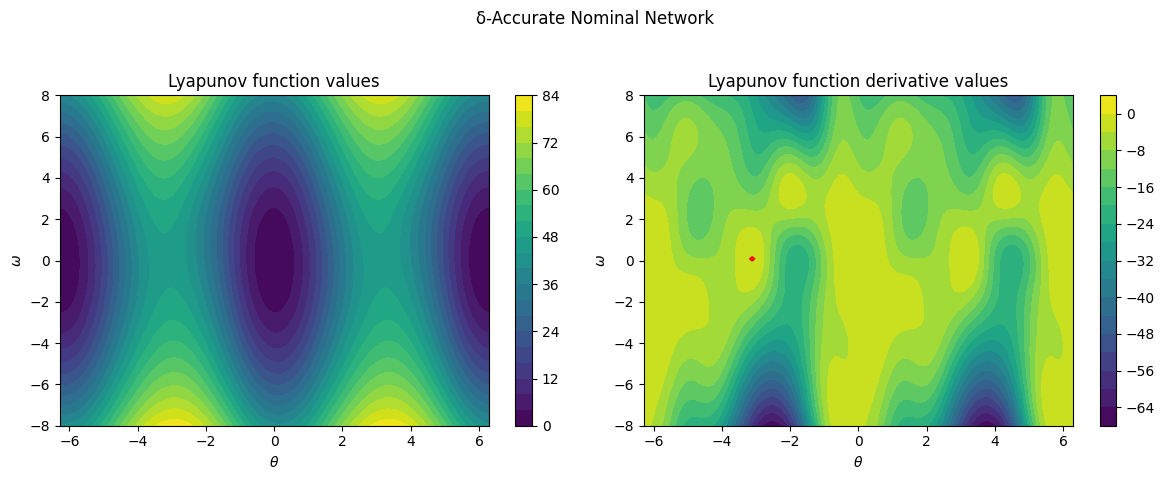

In [14]:

m = 1      #mass
l = 0.5    #length
b = 0.1    #damping
g = 9.81   #gravity

# Define the grid for the pendulum system
theta = np.linspace(-2 * np.pi, 2 * np.pi, 100)
omega = np.linspace(-8, 8, 100)

Theta, Omega = np.meshgrid(theta, omega)
x_grid = np.column_stack([Theta.ravel(), Omega.ravel()])

# Convert theta to cos(theta) and sin(theta)
cos_theta = np.cos(Theta.ravel())
sin_theta = np.sin(Theta.ravel())

# Convert meshgrid to a tensor
x_tensor = torch.Tensor(np.vstack([cos_theta, sin_theta, Omega.ravel()]).T)
x_tensor.requires_grad = True  


def plot_pendulum_lyapunov(net, title):
    # Compute the Lyapunov function values
    V = V_theta(net, x_tensor)
    V = V.detach().numpy().reshape(Theta.shape)

    # Compute the Lyapunov function derivative values
    x_dot = pendulum_dynamics(x_tensor)
    V_dot = torch.autograd.grad(V_theta(net, x_tensor), x_tensor, grad_outputs=torch.ones_like(V_theta(net, x_tensor)), create_graph=True)[0]
    V_dot = torch.sum(V_dot * x_dot, dim=1)
    V_dot = V_dot.detach().numpy().reshape(Theta.shape)

    mask = np.zeros_like(V_dot)
    mask[V_dot >= 0] = 1

    # Plot the Lyapunov function values
    plt.figure(figsize=(12, 5))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.contourf(Theta, Omega, V, levels=20)
    plt.colorbar()
    plt.title("Lyapunov function values")
    plt.xlabel("$\\theta$")
    plt.ylabel("$\omega$")

    # Plot the Lyapunov function derivative values
    plt.subplot(1, 2, 2)
    plt.contourf(Theta, Omega, V_dot, levels=20)
    plt.colorbar()
    plt.title("Lyapunov function derivative values")
    plt.xlabel("$\\theta$")
    plt.ylabel("$\omega$")

    # Highlight regions where the Lyapunov function derivative is non-negative
    plt.contour(Theta, Omega, mask, levels=[0.5], colors='red')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Generate plots for trained networks
delta_symbol = "\u03B4"
plot_pendulum_lyapunov(net_nominal, f"{delta_symbol}-Accurate Nominal Network")
# plot_pendulum_lyapunov(net_cc, "Network CC")        
# plot_pendulum_lyapunov(net_drcc, "Network DRCC")

plt.show()



#Visualize the Real V_dot

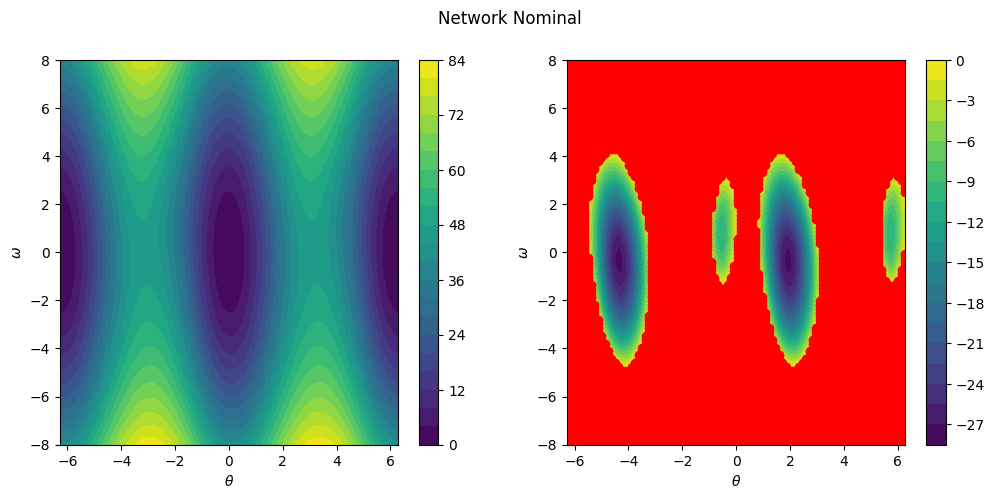

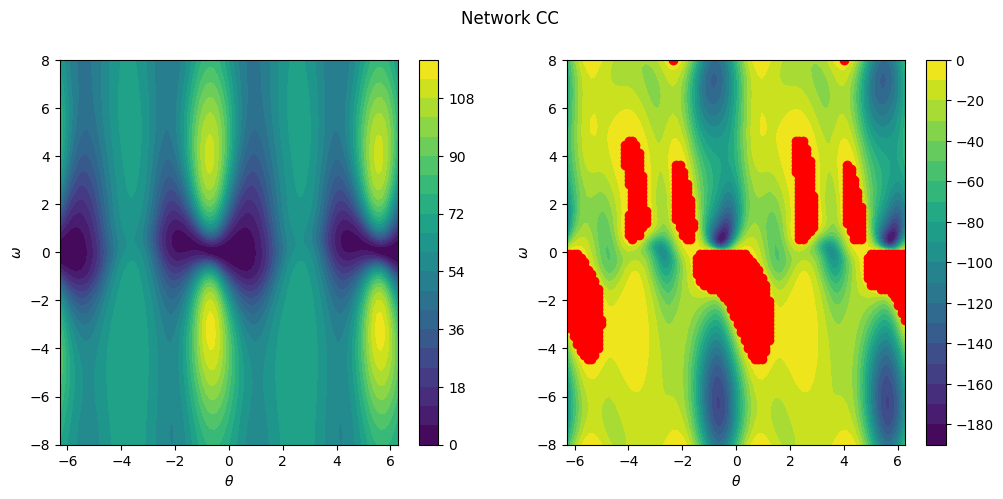

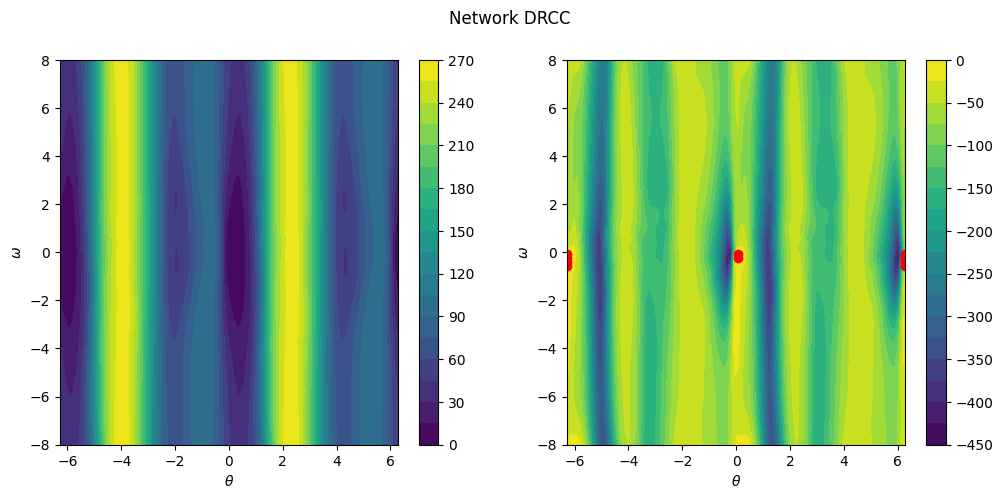

In [72]:
xi_true = torch.tensor([-3.6, 1.4], dtype=torch.float32)

def plot_true_dynamics_lyapunov(net, title, xi_true):
    # Compute the Lyapunov function values
    V = V_theta(net, x_tensor)
    V = V.detach().numpy().reshape(Theta.shape)

    # Compute the Lyapunov function derivative values
    x_dot = real_pendulum_dynamics(x_tensor, xi_true)
    V_dot = torch.autograd.grad(V_theta(net, x_tensor), x_tensor, grad_outputs=torch.ones_like(V_theta(net, x_tensor)), create_graph=True)[0]
    V_dot = torch.sum(V_dot * x_dot, dim=1)
    V_dot = V_dot.detach().numpy().reshape(Theta.shape)

    mask = np.zeros_like(V_dot)
    mask[V_dot >= 0] = 1

    # Set the violations (positive values) to zero for plotting
    V_dot_plot = np.where(V_dot >= 0, 0, V_dot)

    # Find violation points (positive values)
    violation_points = x_grid[V_dot.ravel() >= 0]

    plt.figure(figsize=(12, 5))
    plt.suptitle(title)
    
    # Plot the Lyapunov function values
    plt.subplot(1, 2, 1)
    plt.contourf(Theta, Omega, V, levels=20)
    plt.colorbar()
    #plt.title("Lyapunov function values")
    plt.xlabel("$\\theta$")
    plt.ylabel("$\omega$")

    # Plot the Lyapunov function derivative values
    plt.subplot(1, 2, 2)
    plt.contourf(Theta, Omega, V_dot_plot, levels=20)
    plt.colorbar()
    #plt.title("Lyapunov function derivative values")
    plt.xlabel("$\\theta$")
    plt.ylabel("$\omega$")

    # Scatter violation points
    plt.scatter(violation_points[:, 0], violation_points[:, 1], color='red', label='Violations')
    #plt.legend()

    # the following is for save the derivative plot for L4DC submission
    # plt.figure(figsize=(6, 4.5))  # Create a new figure for the derivative plot
    # plt.contourf(Theta, Omega, V_dot_plot, levels=10)
    # plt.colorbar()
    # plt.xlabel("$\\theta$")
    # plt.ylabel("$\omega$")
    # plt.scatter(violation_points[:, 0], violation_points[:, 1], color='red', label='Violations')

    # # Save the derivative plot
    # plt.savefig("pendulum_drcc_nn.png", dpi=300)

    # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_true_dynamics_lyapunov(net_nominal, "Network Nominal", xi_true)
plot_true_dynamics_lyapunov(net_cc, "Network CC", xi_true)
plot_true_dynamics_lyapunov(net_drcc, "Network DRCC", xi_true)